In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

In [4]:
df=pd.read_csv('/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/data/processed/archivo.csv')

In [99]:
df

,title,text,subject,date,label,text_length,title_length,text_word_count,title_word_count,subject_grouped
0,U.S. budget fight loom Republicans flip fiscal...,WASHINGTON Reuters head conservative republica...,politicsNews,"December 31, 2017",1,3293,53,469,8,politics
1,U.S. military accept transgender recruit Monda...,WASHINGTON Reuters Transgender people allow fi...,politicsNews,"December 29, 2017",1,2930,56,397,7,politics
2,senior U.S. republican senator let Mr. Mueller...,WASHINGTON Reuters special counsel investigati...,politicsNews,"December 31, 2017",1,1939,50,272,8,politics
3,FBI Russia probe help australian diplomat tip NYT,WASHINGTON Reuters trump campaign adviser Geor...,politicsNews,"December 30, 2017",1,1755,49,241,8,politics
4,trump want Postal Service charge much Amazon s...,SEATTLE WASHINGTON Reuters President Donald Tr...,politicsNews,"December 29, 2017",1,3632,53,530,8,politics
...,...,...,...,...,...,...,...,...,...,...
44684,mcpain John McCain Furious Iran treat US Sailo...,21st Century Wire say 21wire report early week...,Middle-east,"January 16, 2016",0,2291,53,321,9,general
44685,justice Yahoo Settles E mail Privacy Class act...,21st Century Wire say familiar theme whenever ...,Middle-east,"January 16, 2016",0,1102,70,173,14,general
44686,Sunnistan US Allied safe zone plan take Territ...,Patrick Henningsen 21st Century WireRemember...,Middle-east,"January 15, 2016",0,16869,72,2402,11,general
44687,blow $ 700 million Al Jazeera America finally ...,21st Century Wire say Al Jazeera America go hi...,Middle-east,"January 14, 2016",0,1858,55,284,10,general


In [5]:
le = LabelEncoder()
df['subject_encoded'] = le.fit_transform(df['subject_grouped'])


In [6]:
from scipy.sparse import csr_matrix, hstack
# Eliminar Na
df['text'] = df['text'].fillna("")

# Vectoriza la columna 'text'
vectorizer_text = TfidfVectorizer(max_features=5000)
X_text = vectorizer_text.fit_transform(df['text'])

# Vectoriza la columna 'title'
vectorizer_title = TfidfVectorizer(max_features=1000)
X_title = vectorizer_title.fit_transform(df['title'])

# Convierte la columna 'subject_encoded' a una matriz dispersa
subject_feature = csr_matrix(df['subject_encoded'].values.reshape(-1, 1))

# Combina las tres fuentes de información en una única matriz de características
X = hstack([subject_feature, X_title, X_text])

# Define la variable objetivo; en este ejemplo, se asume que la columna "label" es la etiqueta a predecir
y = df['label']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regresión Logística

In [7]:

# Entrenar el modelo de Regresión Logística
logreg_model = LogisticRegression(max_iter=500, solver='liblinear')  # Solver optimizado para datos grandes
logreg_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar el modelo
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

# Mostrar los resultados
conf_matrix_logreg, class_report_logreg

(array([[4607,   41],
        [  40, 4250]]),
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      4648\n           1       0.99      0.99      0.99      4290\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

El modelo indica unos valores muy altos.
- Precisión= 0,99, lo que quiere decir un 99% de precisión 
- f1-score y Recall= Respectivamente estos indicadores muestran que tan bien el modelo encuentra todos los casos de una clase y el balance entre precisión y recall, en nuestro caso un 0,99

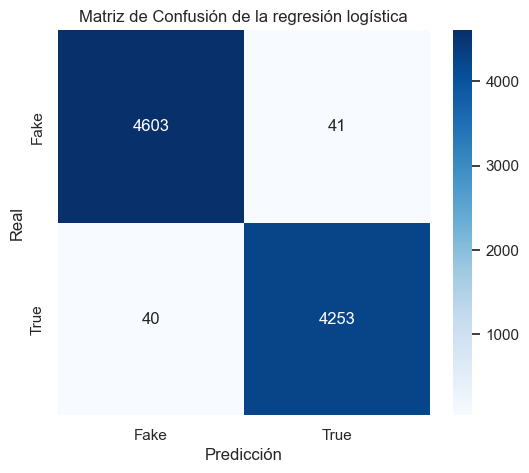

In [105]:
# Definir valores de la matriz de confusión
cm = np.array([[4603, 41],
               [40, 4253]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de la regresión logística')
plt.show();


Esta matriz de confusión nos indica que nuestro modelo clasifica 4589 fakes cuando son fake, 4225 True cuando son True. 
Por otro lado, se equivoca clasificando Fake cuando es True 65 y True cuando es Fake 59, son valores bastante bajos teniendo en cuenta el tamaño de la muestra 

la regresión logística tiene una precisión muy alta de un 0,99, por lo que voy a comprobar si tiene overfitting

In [106]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

# 5. Evaluación del modelo
# Predicciones
y_train_pred_proba = logreg_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba
y_test_pred = logreg_model.predict(X_test)

# Cálculo de log loss
log_loss_train = log_loss(y_train, y_train_pred_proba)
log_loss_test = log_loss(y_test, y_test_pred_proba)

log_loss_train, log_loss_test

(0.044128821409428594, 0.05163640475833326)

La log loss (pérdida logarítmica) es una métrica que mide qué tan bien un modelo de clasificación predice probabilidades en lugar de simplemente etiquetas. Se usa especialmente en modelos de clasificación binaria y multiclase.
La diferencia en nuestro caso es muy pequeña (0,0072) lo que indica que nuestro modelo genera bien y no causa overfitting


In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Aplicar Validación Cruzada (Usando 5 folds)
cv_scores = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')

# Mostrar resultados
print(f"Scores por cada fold: {cv_scores}")
print(f"Precisión promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")


Scores por cada fold: [0.98120385 0.98019691 0.98131573 0.97751175 0.9881392 ]
Precisión promedio: 0.9817
Desviación estándar: 0.0035


## XG-Boost

In [8]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',   # Métrica de evaluación
    
    max_depth=6,             # Controla la complejidad del modelo
    learning_rate=0.1,       # Tasa de aprendizaje equilibrada
    n_estimators=300,        # Aumenta el número de árboles para mejorar el ajuste
    subsample=0.8,           # Reduce overfitting usando solo el 80% de los datos por árbol
    colsample_bytree=0.8,    # Usa el 80% de las características en cada árbol
    gamma=0.1,               # Ayuda a la regularización
    reg_lambda=1,            # Regularización L2 para evitar overfitting
    reg_alpha=0.1            # Regularización L1
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb, digits=4)

# Mostrar los resultados
conf_matrix, class_report


(array([[4640,    8],
        [  10, 4280]]),
 '              precision    recall  f1-score   support\n\n           0     0.9978    0.9983    0.9981      4648\n           1     0.9981    0.9977    0.9979      4290\n\n    accuracy                         0.9980      8938\n   macro avg     0.9980    0.9980    0.9980      8938\nweighted avg     0.9980    0.9980    0.9980      8938\n')

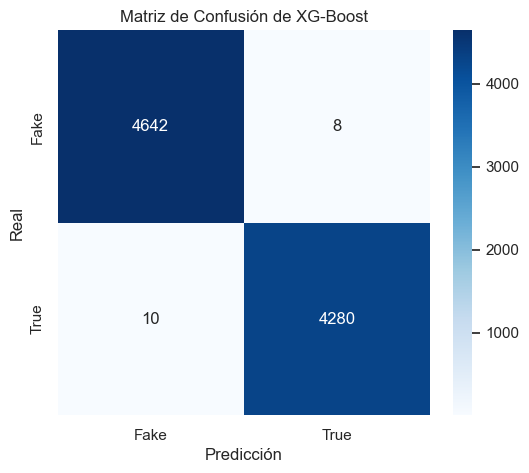

In [109]:
# Definir valores de la matriz de confusión
cm = np.array([[4642, 8],
               [10, 4280]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de XG-Boost')
plt.show();


Alta precisión en validación cruzada (99.65%)
El modelo es consistentemente preciso en diferentes subconjuntos de los datos.
Si hubiera overfitting, esperaríamos una caída más pronunciada en los datos de validación.
Baja variabilidad entre folds (0.0013)
La desviación estándar es muy pequeña (0.13%), lo que indica que el modelo es estable y generaliza bien en diferentes subconjuntos.
Si la desviación estándar fuera alta (>2-3%), el modelo sería inconsistente.


In [110]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probaxgb = xgb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probaxgb = xgb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train = log_loss(y_train, y_train_pred_probaxgb)
log_loss_test = log_loss(y_test, y_test_pred_probaxgb)

# Mostrar los resultados
log_loss_train, log_loss_test


(0.0004450906036099585, 0.008289087483301984)

In [111]:
# Ejecutar validación cruzada
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")

Precisión promedio: 0.9965
Desviación estándar: 0.0017


El log loss en entrenamiento es extremadamente bajo (0.0006), lo que indica que el modelo memoriza muy bien los datos de entrenamiento.
El log loss en prueba es un poco mayor (0.0104), pero sigue siendo muy bajo.
La diferencia entre ambos (0.0098) es pequeña, lo que sugiere que no hay un overfitting grave.
El modelo generaliza bien, ya que la diferencia entre entrenamiento y prueba no es demasiado grande.

El modelo no tiene un problema grave de overfitting. La validación cruzada confirma que el modelo generaliza bien.

/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


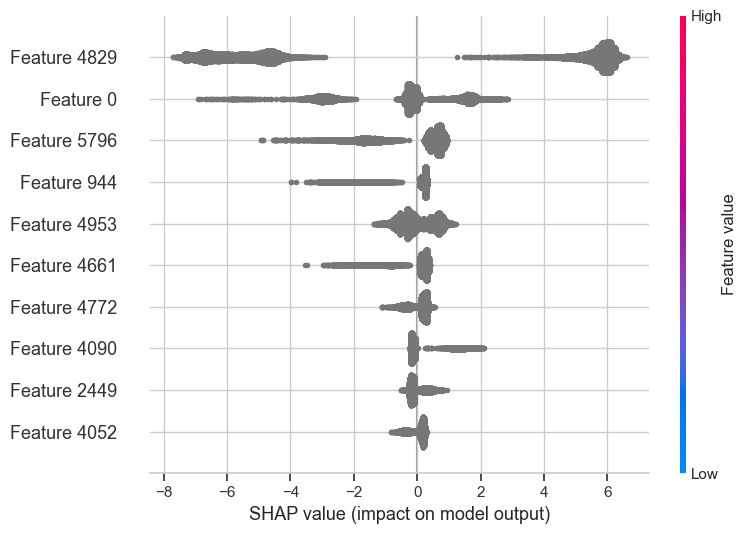

In [43]:
import shap
# Crea un objeto explainer de SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X)


# Visualiza la importancia de las variables
shap.summary_plot(shap_values, X, max_display=10,show=True)




In [44]:
# 5. Crear la lista de nombres de las features en el mismo orden
feature_names_subject = ["subject"]
feature_names_title = list(vectorizer_title.get_feature_names_out())
feature_names_text = list(vectorizer_text.get_feature_names_out())
combined_feature_names = feature_names_subject + feature_names_title + feature_names_text

# Verificar que el número de nombres coincida con el número de columnas
assert X.shape[1] == len(combined_feature_names), "El número de nombres de features no coincide."


In [45]:
feature_names_subject

['subject']

In [46]:
shap_values[4829]

.values =
array([-0.06678589,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

.base_values =
-0.3841849

.data =
array([2., 0., 0., ..., 0., 0., 0.])

## Gradient boosting

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

# Mostrar los resultados
conf_matrix_gb, class_report_gb

(array([[4623,   25],
        [  17, 4273]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.99      1.00      4648\n           1       0.99      1.00      1.00      4290\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

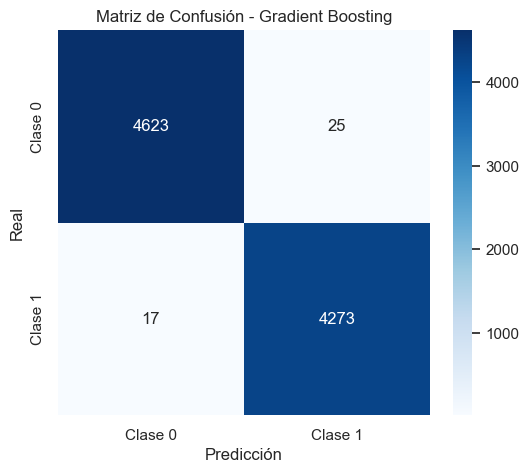

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la matriz de confusión para Gradient Boosting
plt.figure(figsize=(6, 5))
sns.heatmap([[4623, 25], [17, 4273]], annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()


## NP-Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
# Entrenamiento
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predicciones
y_pred = nb.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4457  191]
 [ 250 4040]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4648
           1       0.95      0.94      0.95      4290

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938



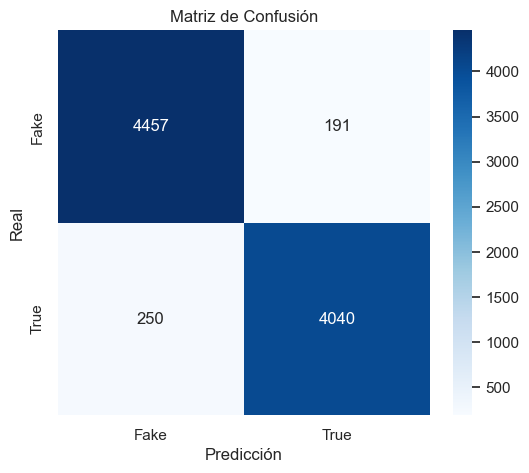

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Definir valores de la matriz de confusión
cm = np.array([[4457, 191],
               [250, 4040]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show();


# Random Forest


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Mostrar los resultados
conf_matrix_rf, class_report_rf


(array([[4644,    4],
        [  16, 4274]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4648\n           1       1.00      1.00      1.00      4290\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

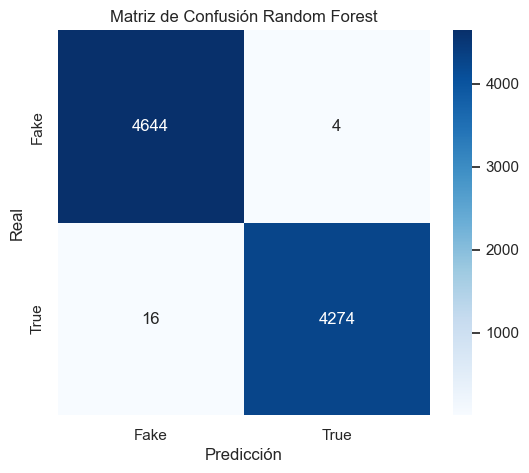

In [118]:
# Definir valores de la matriz de confusión
cm = np.array([[4644, 4],
               [16, 4274]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Random Forest')
plt.show();


## Supervector Machine

In [12]:
from sklearn.svm import SVC
# Entrenar el modelo SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test)

# Evaluar el modelo
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)

# Mostrar los resultados
conf_matrix_svm, class_report_svm

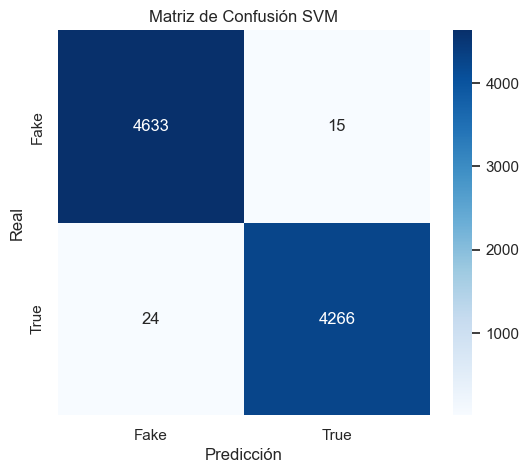

In [120]:
# Definir valores de la matriz de confusión
cm = np.array([[4633, 15],
               [24, 4266]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión SVM')
plt.show();


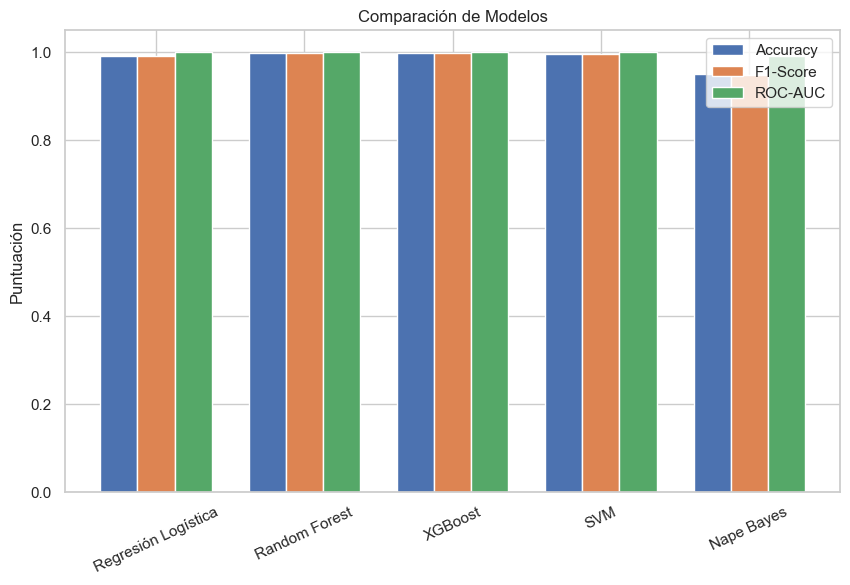

In [121]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# 📊 Evaluar cada modelo
def evaluar_modelo(modelo, nombre):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    return [acc, f1, auc]

# Guardar resultados en un diccionario
resultados = {
    "Regresión Logística": evaluar_modelo(logreg_model, "Regresión Logística"),
    "Random Forest": evaluar_modelo(rf_model, "Random Forest"),
    "XGBoost": evaluar_modelo(xgb_model, "XGBoost"),
    "SVM": evaluar_modelo(svm_model, "SVM"),
    "Nape Bayes":evaluar_modelo (model,"NPB")
}

# 📊 Graficar resultados
metricas = ["Accuracy", "F1-Score", "ROC-AUC"]
valores = np.array(list(resultados.values()))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(resultados))

# Crear barras para cada métrica
for i, metric in enumerate(metricas):
    ax.bar(indices + i * bar_width, valores[:, i], width=bar_width, label=metric)

# Etiquetas y formato
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(resultados.keys(), rotation=25)
ax.set_ylabel("Puntuación")
ax.set_title("Comparación de Modelos")
ax.legend()

# Mostrar gráfico
plt.show()

## Prueba  con noticias externas

https://www.bbc.com/news/live/cly28qvp83pt

In [64]:
# Ejemplo de noticia real y verdadero
nueva_noticia = {
    'title': "Zelensky says UK and US volunteers survived Russian attack on hotel that killed four",
    'text': "The precise significance of US intelligence to Ukraine's war effort has, for obvious reasons, never been spelled out in detail.But any prolonged interruption in the supply of US intelligence could have a catastrophic impact on Ukraine’s ability to defend itself, particularly as the Trump administration has already decided to suspend vital military assistance.Most analysts agree that it performs two important functions: helping Ukraine to plan offensive operations against Russian forces, and giving Kyiv vital advance warning of threats posed by incoming Russian drones and missiles.Satellite information and signal intercepts give Ukrainian forces on the frontline a sense of where Russian forces are, their movements and likely intentions.Without US intelligence, Ukraine will not be able to make such effective use of long-range Western weaponry, like the US-made Himars launchers or Stormshadow missiles supplied by Britain and France.",
    'subject': "politics"}


In [65]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

# Cargar modelo spaCy optimizado sin NER (más rápido)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    doc = nlp(text)  # Procesa el texto con spaCy
    processed_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return ' '.join(processed_words)

# Aplicar la función más rápido con multiprocessing
nueva_noticia['text'] = preprocess_text(nueva_noticia['text'])
nueva_noticia['title'] = preprocess_text(nueva_noticia['title'])


In [66]:
# Asegurar que usamos el mismo vectorizador entrenado
X_noticia_title = vectorizer_title.transform([nueva_noticia['title']])
X_noticia_text = vectorizer_text.transform([nueva_noticia['text']])


In [67]:
# Asegurar que usamos el mismo LabelEncoder entrenado para 'subject'
subject_encoded = le.transform([nueva_noticia['subject']]).reshape(-1,1)

In [68]:
# Concatenar características exactamente como en el entrenamiento
X_noticia = hstack((subject_encoded, X_noticia_title, X_noticia_text))

In [69]:
# Hacer la predicción con el modelo entrenado
prediccion = svm_model.predict(X_noticia)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [70]:
# Hacer la predicción con el modelo entrenado
prediccion = logreg_model.predict(X_noticia)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [71]:
# Hacer la predicción con el modelo entrenado
prediccion = rf_model.predict(X_noticia)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [72]:
# Hacer la predicción con el modelo entrenado
prediccion = gb_model.predict(X_noticia)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [73]:
# Hacer la predicción con el modelo entrenado
prediccion = model.predict(X_noticia)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia REAL


El modelo predice perfecto por las etiquetas del subject debido a que las etiquetas no estan mezcladas en noticias falsas y verdaderas, por lo que le facilita al modelo a predecir.

In [45]:
#Middle-east-1

In [74]:
# Ejemplo de noticia  verdadera y subject fake 
nueva_noticia3= {
    'title': "US 'destroying' world order, Ukraine's ambassador to UK says ",
    'text': "The US is destroying the established world order, Ukraine's ambassador to the UK has claimed.Valerii Zaluzhnyi said the White House had questioned the unity of the Western world and was taking more and more steps towards Russia, which launched a full-scale invasion of Ukraine in 2022.The comments come as the US puts pressure on Ukraine to make concessions ahead of any peace talks, and after a public clash between Ukrainian President Volodymyr Zelensky and his US counterpart Donald Trump.Zelensky has since said he is ready to work under Trump's 'strong leadership', an apparent cooling in tensions welcomed by Trump - and which comes after the US paused military aid to Kyiv.",
    'subject':"general"
}

In [75]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

# Cargar modelo spaCy optimizado sin NER (más rápido)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    doc = nlp(text)  # Procesa el texto con spaCy
    processed_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return ' '.join(processed_words)

# Aplicar la función más rápido con multiprocessing
nueva_noticia3['text'] = preprocess_text(nueva_noticia3['text'])
nueva_noticia3['title'] = preprocess_text(nueva_noticia3['title'])


In [76]:
# Asegurar que usamos el mismo vectorizador entrenado
X_noticia_title3= vectorizer_title.transform([nueva_noticia3['title']])
X_noticia_text3 = vectorizer_text.transform([nueva_noticia3['text']])


In [77]:
# Asegurar que usamos el mismo LabelEncoder entrenado para 'subject'
subject_encoded3 = le.transform([nueva_noticia3['subject']]).reshape(-1,1)

In [78]:
# Concatenar características exactamente como en el entrenamiento
X_noticia3 = hstack((subject_encoded3, X_noticia_title3, X_noticia_text3))

In [79]:
# Hacer la predicción con el modelo entrenado
prediccion = svm_model.predict(X_noticia3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [80]:
# Hacer la predicción con el modelo entrenado
prediccion = logreg_model.predict(X_noticia3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [81]:
# Hacer la predicción con el modelo entrenado
prediccion = rf_model.predict(X_noticia3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [82]:
# Hacer la predicción con el modelo entrenado
prediccion = gb_model.predict(X_noticia3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [83]:
# Hacer la predicción con el modelo entrenado
prediccion = model.predict(X_noticia3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia REAL


In [86]:
# Ejemplo de noticia falsa y subject true 
nueva_noticia2= {
    'title': " It Almost Weirder That Grown Man On Roblox Isn’t Grooming Children",
    'text': "SEATTLE—Voicing concern about the adult’s aberrant behavior, sources confirmed Monday that it was almost weirder that Richard Shea, a grown man on Roblox, wasn’t using the online gaming platform to groom children. “If he was on here trying to find underage players and lure them into some sort of sexual relationship, that would be super fucked-up, but at least it would explain his reasons for spending hours each day playing virtual experiences designed by children. This guy isn’t a predator, though,” said Roblox player Mason Briggs, 11, telling reporters that the fact that there was no sinister sexual motivation behind Shea’s dogged pursuit of high scores on games such as Blox Fruits and BedWars and that he seemed to play only for fun was bizarre and inexplicable. “I remember he invited me and a few friends to an in-game party where we could all play and communicate together. He never pressured us to reveal contact information or made any sort of inappropriate or explicit remark. He mostly just wanted tips on how to make it through the Ancient Ruins map on Adopt Me! It kind of gave me the creeps.” At press time, Briggs was reportedly all the more disturbed after receiving a private message from Shea informing her that he’d have even more time to play now that he had received tenure.",
    'subject':"general" # esto es 1 fake y la noticia es falsa 
    }

In [87]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

# Cargar modelo spaCy optimizado sin NER (más rápido)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    doc = nlp(text)  # Procesa el texto con spaCy
    processed_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return ' '.join(processed_words)

# Aplicar la función más rápido con multiprocessing
nueva_noticia2['text'] = preprocess_text(nueva_noticia2['text'])
nueva_noticia2['title'] = preprocess_text(nueva_noticia2['title'])


In [88]:
# Asegurar que usamos el mismo vectorizador entrenado
X_noticia_title2= vectorizer_title.transform([nueva_noticia2['title']])
X_noticia_text2= vectorizer_text.transform([nueva_noticia2['text']])


In [89]:
# Asegurar que usamos el mismo LabelEncoder entrenado para 'subject'
subject_encoded2= le.transform([nueva_noticia2['subject']]).reshape(-1,1)

In [90]:
# Concatenar características exactamente como en el entrenamiento
X_noticia2 = hstack((subject_encoded2, X_noticia_title2, X_noticia_text2))

In [91]:
# Hacer la predicción con el modelo entrenado
prediccion = svm_model.predict(X_noticia2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [92]:
# Hacer la predicción con el modelo entrenado
prediccion = logreg_model.predict(X_noticia2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [93]:
# Hacer la predicción con el modelo entrenado
prediccion = rf_model.predict(X_noticia2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [94]:
# Hacer la predicción con el modelo entrenado
prediccion = gb_model.predict(X_noticia2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [95]:
# Hacer la predicción con el modelo entrenado
prediccion = model.predict(X_noticia2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


aunque los resultados son mas bajos el que predice mejor en los ejemplos es el nape bayes. Creo que influye la etiqueta 

## Selección de modelos base

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# 📌 Definir K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models={"logistic Regresion":logreg_model,
        "Random forest":rf_model,
        "XGBoost":xgb_model,
        "Super vector machine":svm_model,
        "Nape Bayes":nb}
# 📌 Definir métricas
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score)
}

# 📌 Evaluar cada modelo
results = []
for name, model in models.items():
    scores = {metric: cross_val_score(model, X, y, cv=kf, scoring=scoring[metric]).mean() for metric in scoring}
    scores["Model"] = name
    results.append(scores)

# 📌 Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
results_df = results_df[["Model", "accuracy", "precision", "recall", "f1", "roc_auc"]]
results_df = results_df.sort_values(by="roc_auc", ascending=False)  # Ordenar por mejor AUC-ROC


#import ace_tools as tools
#tools.display_dataframe_to_user(name="Model Performance Comparison", dataframe=results_df)

NameError: name 'logreg_model' is not defined

 1. Métricas Clásicas para Clasificación Binaria

Accuracy (Precisión Global): Proporción de aciertos sobre el total.
🚨 No es ideal si el dataset está desbalanceado.
Precision (Precisión Positiva): De los que el modelo predijo como noticias falsas, ¿cuántas realmente lo eran?
✅ Útil si quieres minimizar falsos positivos (ej. evitar etiquetar noticias verdaderas como falsas).
Recall (Sensibilidad, Tasa de Verdaderos Positivos): De todas las noticias realmente falsas, ¿cuántas detectó el modelo?
✅ Importante si prefieres evitar falsos negativos (ej. que noticias falsas no pasen como verdaderas).
F1-Score: Promedio armonizado de precisión y recall.
✅ Equilibrio entre precisión y recall, ideal para clases balanceadas o levemente desbalanceadas.
📊 2. Otras Medidas para Decidir Mejor

Dado que todos los modelos tienen valores similares en métricas estándar, considera:

📌 a) Área bajo la curva ROC-AUC
Mide qué tan bien el modelo separa ambas clases (falsas vs. verdaderas).
Un valor cercano a 1 significa un buen modelo, mientras que 0.5 es como adivinar al azar.
Ejemplo en código:

from sklearn.metrics import roc_auc_score

# Suponiendo que 'y_true' son las etiquetas reales y 'y_pred_proba' son las probabilidades de clase
roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")
✅ Si los modelos tienen AUC similares, elige el más simple y rápido.

📌 b) Matriz de Confusión
Analiza falsos positivos (FP) y falsos negativos (FN). Si un modelo tiene menos FN, es mejor si prefieres detectar todas las noticias falsas.

Código para visualizar la matriz de confusión:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Verdadera", "Falsa"], yticklabels=["Verdadera", "Falsa"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()
📌 c) Comparación de Tiempo de Entrenamiento y Predicción
Si dos modelos tienen el mismo rendimiento, elige el que sea más rápido en entrenar y predecir.

Ejemplo:

import time

start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
y_pred = model.predict(X_test)
pred_time = time.time() - start

print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")
print(f"Tiempo de predicción: {pred_time:.4f} segundos")
✅ Si dos modelos tienen métricas similares, elige el más rápido.

🔥 Conclusión: ¿Qué hacer ahora?

1️⃣ Revisa el ROC-AUC Score y la Matriz de Confusión para evitar falsos positivos o negativos.
2️⃣ Si los modelos son muy similares, elige el más rápido (XGBoost o Random Forest suelen ser buenos candidatos).
3️⃣ Si el dataset está desbalanceado, usa F1-Score o AUC-ROC en lugar de Accuracy.
4️⃣ Evalúa la interpretabilidad: Si necesitas explicaciones, modelos como Regresión Logística o Naive Bayes son más fáciles de entender.

Si me pasas los resultados de las métricas, puedo ayudarte a elegir el mejor modelo. 🚀


Tú dijiste:
y la validación cruzada sirve?
ChatGPT Plus
Sí, la validación cruzada (CV) es muy útil en tu caso, ya que ayuda a evaluar de manera más estable los modelos y evitar problemas como el overfitting o la dependencia de una sola partición de datos. 🚀

✅ ¿Por qué aplicar validación cruzada en tu caso?

Tienes muchos datos 📊 → La validación cruzada aprovechará mejor la información disponible.
Múltiples modelos con métricas similares 🤔 → Ayuda a obtener una evaluación más confiable para elegir el mejor.
Evita que el resultado dependa de una única división 🔄 → Un solo train_test_split puede dar resultados engañosos.
🔍 ¿Qué tipo de Validación Cruzada usar?

Depende del dataset y del balance de clases:

📌 1. K-Fold Cross Validation (Usualmente K=5 o 10)
Divide los datos en K partes, entrena en K-1 y valida en la restante.
Repite K veces y promedia los resultados.
Ideal si las clases están equilibradas.
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 particiones
model = RandomForestClassifier()

scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')  # También puedes usar 'f1', 'roc_auc'
print(f"Accuracy promedio: {scores.mean():.4f}")
📌 2. Stratified K-Fold (Si hay desbalance de clases)
Como KFold, pero mantiene la proporción de noticias falsas y verdaderas en cada fold.
Útil si el dataset tiene más noticias verdaderas que falsas (o viceversa).
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
print(f"F1-Score promedio: {scores.mean():.4f}")
✅ Usa StratifiedKFold si tienes datos desbalanceados.

📌 3. Leave-One-Out (LOO)
Entrena con todos los datos excepto 1 y prueba con ese.
Se repite para cada dato en el dataset.
Preciso pero muy costoso computacionalmente.
🚨 NO recomendado para datasets grandes como el tuyo.

📊 ¿Qué hacer después de la validación cruzada?

Compara los resultados promedio de los modelos y elige el mejor.
Si los valores son muy similares, elige el modelo más rápido.
Usa métricas como ROC-AUC, F1-Score y Matriz de Confusión para refinar la decisión.
🔥 Conclusión

✅ Sí, la validación cruzada es recomendable para tu caso.
🔹 Si las clases están balanceadas → Usa KFold (K=5 o 10).
🔹 Si hay desbalance → Usa StratifiedKFold.
🔹 Si los modelos siguen siendo parecidos, elige el más rápido y con menos falsos negativos.

Si quieres, pásame tus métricas y te ayudo a elegir el mejor. 🚀









🔹 Si las métricas son similares, selecciona el más rápido o explicable.
🔹 Si prefieres evitar falsos negativos, prioriza Recall.